# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [27]:
target = TuringTarget(stat_model);

In [28]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(1, Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [29]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true);

eps: 0.5 --> VarE: 974.5882090469048
eps: 

[ Info: Tuning eps ⏳


0.25 --> VarE: 9.085648374059966
eps: 0.125 --> VarE: 23.567416744565747
eps: 0.0625 --> VarE: 3.5430143507134573
eps: 0.03125 --> VarE: 0.776184479229095
samples: 100--> ESS: 0.024237766308085877
samples: 243--> ESS: 0.01945688970043973
samples: 447--> ESS: 0.006280659647220325
samples: 739--> ESS: 0.020341756238449624


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 0.6144995473091318 ✅


In [30]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

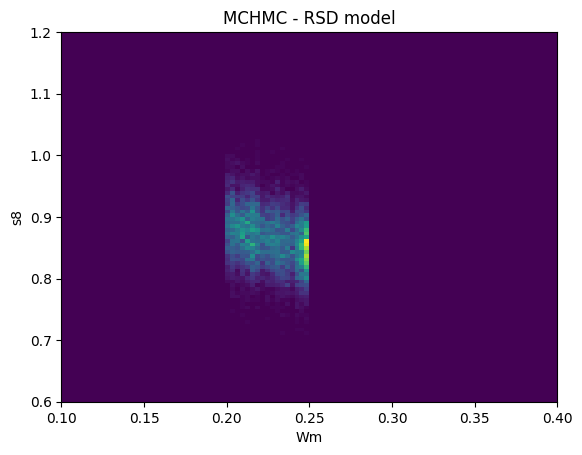

In [31]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [40]:
nchains = 100
e_spl = MCHMC(spl.hyperparameters.eps, spl.hyperparameters.L, nchains)

MicroCanonicalHMC.EnsembleSampler(Settings(100, Random.MersenneTwister(0), 0.2, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.03125, 0.6144995473091318, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [41]:
samples_ensemble_mchmc = Sample(e_spl, target, 10000, 1000;
   monitor_energy=true, 
   dialog=true);

[ Info: Using given hyperparameters
[ Info: Found eps: 0.03125 ✅
[ Info: Found L: 0.6144995473091318 ✅


In [42]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

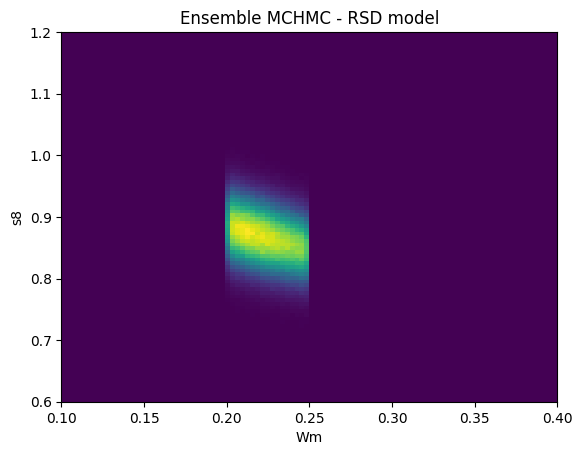

In [43]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

## AbstractMCMC

In [16]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 23.599877489451632
eps: 

[ Info: Tuning eps ⏳


0.25 --> VarE: NaN
eps: 0.125 --> VarE: 25.138998473569668
eps: 0.0625 --> VarE: 4.296453354560666
eps: 0.03125 --> VarE: 1.7761088299253593
samples: 100--> ESS: 0.024283494706402838
samples: 243--> ESS: 0.011844504100199889
samples: 447--> ESS: 0.020375368715122053
samples: 739--> ESS: 0.01990847221033934


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.01 seconds
Compute duration  = 2.01 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2248    0.0119     0.0001    0.0011     44.0343    1.0484    ⋯
          σ8    0.8655    0.0409     0.0004    0.0009   2806.1779    1.0030    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2024    0.2149    0.2256    0.2338    0.2459
          σ8    0.7861    0.8384    0.8658    0.8930    0.9452


In [17]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.61 seconds
Compute duration  = 0.61 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2272    0.0130     0.0001    0.0012     34.0217    1.0258    ⋯
          σ8    0.8638    0.0408     0.0004    0.0009   2800.4010    1.0021    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2065    0.2162    0.2263    0.2376    0.2496
          σ8    0.7839    0.8364    0.8633    0.8910    0.9435


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 74.44133648574237
eps: 0.25 --> VarE: NaN


[ Info: Tuning eps ⏳


eps: 0.125 --> VarE: 25.452147234442833
eps: 0.0625 --> VarE: 15.78062406455372
eps: 0.03125 --> VarE: 8.051699618329222
eps: 0.015625 --> VarE: 2.8072505531852263
eps: 0.0078125 --> VarE: 0.7793015279163957
samples: 100--> ESS: 0.02137942628876728
samples: 243--> ESS: 0.009814057940209144
samples: 447--> ESS: 0.02091901370899682
samples: 739--> ESS: 0.019620101430319184


[ Info: Found eps: 0.0078125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
chain 4:   5%|██▏                                       |  ETA: 0:00:02


chain 2:   4%|█▉                                        |  ETA: 0:00:02
chain 3:   5%|██▏                                       |  ETA: 0:00:02
chain 1:   4%|█▌                                        |  ETA: 0:00:03

chain 3:  10%|████                                      |  ETA: 0:00:02chain 2:  10%|████                                      |  ETA: 0:00:02
chain 4:  11%|████▋                                     |  ETA: 0:00:02


chain 1:   8%|███▍                                      |  ETA: 0:00:03
chain 2:  14%|██████▏                                   |  ETA: 0:00:02
chain 3:  14%|██████▏                                   |  ETA: 0:00:02


chain 4:  16%|██████▉                                   |  ETA: 0:00:02
chain 1:  12%|█████▎                                    |  ETA: 0:00:02

chain 2:  20%|████████▋                  

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 2:   8%|███▏                                      |  ETA: 0:00:02



chain 4:  10%|████                                      |  ETA: 0:00:02
chain 3:  10%|████▎                                     |  ETA: 0:00:02


chain 1:  10%|████                                      |  ETA: 0:00:02

chain 2:  14%|█████▉                                    |  ETA: 0:00:02
chain 4:  16%|██████▊                                   |  ETA: 0:00:01

chain 3:  17%|███████▏                                  |  ETA: 0:00:01
chain 1:  15%|██████▎                                   |  ETA: 0:00:02





chain 2:  20%|████████▋                                 |  ETA: 0:00:01
chain 4:  22%|█████████▌                                |  ETA: 0:00:01

chain 3:  23%|█████████▋                                |  ETA: 0:00:01

chain 1:  21%|████████▉                                 |  ETA: 0:00:02

chain 3:  28%|████████████                              |  ETA: 0:00:01
chain 2:  27%|

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:11┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be reje

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 4.94 seconds
Compute duration  = 4.94 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2241    0.0143     0.0001    0.0002   7329.7688    0.9999    ⋯
          σ8    0.8662    0.0388     0.0004    0.0005   6732.1913    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.236694  0.873417  15.9971  3.0  1.0  …  2.0  0.0  0.905401  0.905401
 0.24319   0.876524  15.3369  3.0  1.0     2.0  0.0  0.905401  0.905401
 0.246478  0.860467  14.9081  3.0  1.0     2.0  0.0  0.905401  0.905401
 0.224697  0.897129  16.0352  7.0  1.0     2.0  0.0  0.905401  0.905401
 0.217176  0.89782   16.0551  3.0  1.0     2.0  0.0  0.905401  0.905401
 0.215763  0.870906  16.2558  3.0  1.0  …  1.0  0.0  0.905401  0.905401
 0.237183  0.896065  15.4975  3.0  1.0     2.0  0.0  0.905401  0.905401
 0.241317  0.853554  15.768   7.0  1.0     2.0  0.0  0.905401  0.905401
 0.220634  0.875642  16.351   7.0  1.0     2.0  0.0  0.905401  

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

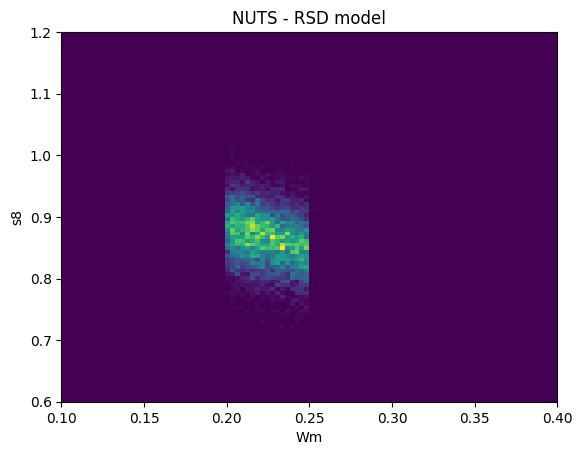

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");